In [1]:
from oop_functions.analytics_functions import run_classifier, performance_analysis
from oop_functions.missing_values_functions import print_records_vs_unique, impute_with_val
from oop_functions.util_functions import summarize_features, print_df, get_cols_missing_percentage, \
    get_unique_combinations
from processing_functions import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.feature_selection import (SelectFromModel, SelectKBest, f_classif)
from sklearn.metrics import (f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import time
import xgboost as xgb
from scipy.spatial import distance
import itertools


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
missing_df = pd.read_csv('./missing_features/combined_missing.csv', index_col=0)

In [3]:
screen_data_cols = ['study_yr', 'detl_p', 'detr_p', 'lvol_p', 'rvol_p', 'lvol_q', 'rvol_q',
       'lantero_p', 'lantero_q', 'llong_p', 'llong_q', 'ltran_p', 'ltran_q',
       'rantero_p', 'rantero_q', 'rlong_p', 'rlong_q', 'rtran_p', 'rtran_q',
       'tvu_ref', 'phycons', 'tvu_result', 'ca125_result', 'ovar_result',
       'ovcyst_solidr', 'ovcyst_outliner', 'ovcyst_solidl', 'ovcyst_outlinel',
       'ovcyst_solid', 'ovcyst_outline', 'ovcyst_diamr', 'ovcyst_diaml',
       'ovcyst_diam', 'ovcyst_volr', 'ovcyst_voll', 'ovcyst_vol',
       'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr',
       'ovcyst_suml', 'ovcyst_sum', 'ovary_diam', 'ovary_diamr', 'ovary_diaml',
       'ovary_volr', 'ovary_voll', 'ovary_vol', 'visl', 'visr', 'visboth',
       'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ovar_days']

screen_abnorm_data_cols = ['study_yr', 'solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum',
       'plco_id']

screened_cols = screen_data_cols + screen_abnorm_data_cols + ['ca125ii', 'ca125_result']

## Merging Datasets

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` Run model purely on family history variables vs purely on screen variables. 

`TODO:` turn all of this into OOP programming

`TODO:` include the level of missingness for a particular features of a tree in order of usage.

`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

`TODO:` try SVM or ML models

`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

In [4]:

def feature_selection(classifier, fn, accuracy, plot_tree=False, filepath='./trees/decision_tree.png'):
    
    if plot_tree:
        cn=['no cancer', 'cancer']
        if classifier.__class__.__name__ == 'DecisionTreeClassifier':
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            tree.plot_tree(classifier,
                        max_depth=5,
                feature_names = fn, 
                class_names=cn,
                filled = True)
            plt.savefig(filepath)
            # plt.show()
        if classifier.__class__.__name__ == 'XGBClassifier':
            # fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=6000)
            # plt.gcf().set_size_inches(18.5, 10.5)
            xgb.plot_tree(classifier, rankdir='LR', ax=axes)
            plt.savefig(filepath)
    feature_importances = pd.DataFrame(classifier.feature_importances_,
                        index = fn,
                        columns=['importance']).sort_values('importance', 
                                                            ascending=False)
    feature_importances['column_name'] = feature_importances.index
    feature_importances = feature_importances[['column_name', 'importance']]
    # TODO: boundary and confusion matrix
    tree_depth = None
    if classifier.__class__.__name__ == 'DecisionTreeClassifier':
        tree_depth = classifier.tree_.max_depth
    if classifier.__class__.__name__ == 'XGBClassifier':
        tree_depth = classifier.max_depth
    top_feature_stats = {
        'top_feature': feature_importances.iloc[0]['column_name'],
        # 'boundary': 0,
        'num_features_used': len(feature_importances[feature_importances['importance'] > 0]),
        'importance': round(feature_importances.iloc[0]['importance'], 3),
        'tree_depth': tree_depth,
        'accuracy': accuracy,
        # 'precision': precision,
        # 'recall':    recall,
        # 'f1-score':  f1,
    }
    return top_feature_stats, feature_importances



In [5]:
def get_cv_scores(classifier, k_fold_lambdas):
    cv_scores = []
    # pipeline = make_pipeline(StandardScaler(), classifier)
    df_feature_importance_tree = None
    for k, k_fold_lambda in enumerate(k_fold_lambdas):
        X_train, X_test, y_train, y_test = k_fold_lambda()
        # pipeline.fit(X_train_cv, y_train_cv)
        # score = pipeline.score(X_test_cv, y_test_cv)
        trained_classifier, auc, accuracy, threshold, report = run_classifier(classifier, X_train, X_test, y_train, y_test, show_graph=False)
        cv_scores.append(report)
        # print(f'Fold: {k+1}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Auc: {auc:.3f}')
        # Decision Tree feature selection
        if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
            fn=X_train.columns
            top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=False)
            feature_importances = feature_importances[feature_importances['importance'] > 0]
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{k}', f'_tiral_{k+1}'])
            else:
                df_feature_importance_tree = feature_importances
    cv_scores = pd.concat(cv_scores)
    cv_scores = cv_scores.reset_index()
    cv_scores = cv_scores.drop('index', axis=1)
    measures_df = cv_scores.describe().T[['mean', 'std', 'min', 'max']]
    print('\n\nCross-Validation measures:')
    print_df(measures_df)
    if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
        # Mean of feature importance over trials
        df_feature_importance_mean = df_feature_importance_tree.drop('column_name', axis=1)
        df_feature_importance_mean = df_feature_importance_mean.T
        df_feature_importance_mean.columns = df_feature_importance_tree['column_name']
        df_feature_importance_mean = df_feature_importance_mean.astype('float')
        df_feature_importance_mean_describe = df_feature_importance_mean.describe().T
        df_feature_importance_mean_describe.sort_values('mean', ascending=False, inplace=True)
        # print(df_feature_importance_mean_describe.columns)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe[['count', 'mean']]
        # print_df(df_feature_importance_mean_describe)
    df_feature_importance_mean_describe = df_feature_importance_mean_describe.merge(missing_df, on='column_name')
    return cv_scores, measures_df, df_feature_importance_mean_describe


In [6]:
def scale_features(df):
    sc = StandardScaler()
    df_scaled = df.copy()
    df_scaled = sc.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

In [7]:
def get_nearest_neighbors(df1, df2, top=5):
    df1 = df1.drop_duplicates()
    df2 = df2.drop_duplicates()
    df1 = scale_features(df1)
    df2 = scale_features(df2)
    euclidean_distances = []
    indexes = []
    for i in range(len(df1)):
        row1 = df1.iloc[i]
        distances = []
        for j, row2 in df2.iterrows():
            distances.append((j, distance.euclidean(row1, row2)))
        distances = sorted(distances, key=lambda x: x[1], reverse=False)[:top]
        distances = pd.DataFrame(distances, columns=['index', 'distance'])
        indexes.append((distances['index'].to_list()))
        euclidean_distances.append(distances['distance'].to_list())
    return euclidean_distances, indexes

def get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0):
    # Insert predicted class and its likelihood
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    X_test_mismatch = X_test.copy()
    X_test_mismatch[label] = y_test
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    
    # X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] < 0.2) | (X_test_mismatch[f'{label}_prob'] > 0.8)]
    X_test_high_conf = X_test_mismatch
    X_test_high_conf = X_test_high_conf[X_test_high_conf[f'{label}_pred'] == label_val]
    
    # Select 5 nearest neightbors 
    X_train[label] = y_train
    X_train_filtered = X_train[X_train[label] == label_val].drop(label, axis=1)
    # X_test_high_conf = X_test.loc[X_test_high_conf.index, :]
    # Calculated euclidean distances
    distances, indices = get_nearest_neighbors(X_test.loc[X_test_high_conf.index, :], X_train_filtered)
    fp_mismatches = []
    X_train[f'{label}_pred'] = -1
    X_train[f'{label}_prob'] = -1
    X_train = X_train.drop_duplicates()
    # print_df(X_train)
    for i in range(len(X_test_high_conf)):
        idx = indices[i]
        missed_record = X_test_high_conf.iloc[[i], :]
        missed_record['distance'] = 0
        close_records = X_train.loc[idx, :]
        close_records['distance'] = distances[i]
        fp_mismatches.append((missed_record, close_records))
    return fp_mismatches

In [8]:
def run_classifiers(classifiers, df, label, strategy='median', drop_n_features = 1, num_folds=10, cv=False, plot_tree=False, differentiate_confusion_matrix_over=None):
    df_feature_importance_tree = None
    df_top_feature_importances = []
    for i in range(drop_n_features):
        
        train_test_lambda, k_fold_lambdas = process_and_impute_for_label_kfold(df, label, strategy, n_max_per_class=10000, num_folds=num_folds, differentiate_confusion_matrix_over=differentiate_confusion_matrix_over)
        X_train, X_test, y_train, y_test, differentiated_test_sets = train_test_lambda()
        auc_dict = {}
        accuracy_dict = {}
        top_feature_importance = []
        for classifier_type, classifier in classifiers.items():
            # Cross Validation
            if cv:
                cv_scores, measures_df, df_feature_importance_mean_describe = get_cv_scores(classifier, k_fold_lambdas)
                cv_scores.to_csv(f'./cv_scores/cv_scores_for_{classifier_type}_{label}.csv')
                measures_df.to_csv(f'./cv_scores/cv_stats_for_{classifier_type}_{label}.csv')
                if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                    df_feature_importance_mean_describe.to_csv(f'./feature_importance/feature_importance_mean_{classifier_type}_{label}__{num_folds}_trials.csv')

            # Test classifier
            print(classifier_type)
            trained_classifier, auc, accuracy, threshold, report = run_classifier(classifier, X_train, X_test, y_train, y_test)
            print(threshold)
            filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
            for i, (X_test_filtered, y_test_filtered) in enumerate(differentiated_test_sets):
                print(f'Filtered on: {filtered_on[i]}')                
                y_pred = trained_classifier.predict(X_test_filtered)
                y_prob = trained_classifier.predict_proba(X_test_filtered)[:,1]
                performance_analysis(y_pred, y_prob, y_test_filtered, show_graph=True)

            # Decision Tree feature selection
            if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                fn=X_train.columns
                top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=plot_tree,
                                                                                         filepath=f'./trees/decision_tree_for_{classifier_type}_{label}.png')
                df_top_feature_importances.append(top_feature_stats)
                top_feature_importance.append(feature_importances.iloc[0]['column_name'])
                feature_importances = feature_importances[feature_importances['importance'] > 0]
                if df_feature_importance_tree is not None:
                    df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
                else:
                    df_feature_importance_tree = feature_importances
            auc_dict[classifier_type] = auc
            accuracy_dict[classifier_type] = accuracy
            
            fp_mismatches = get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0)
        # df = df.drop(top_feature_importance, axis=1)

    return df_top_feature_importances, df_feature_importance_tree, fp_mismatches



In [9]:
differentiate_confusion_matrix_over = {
    'was_screened': [[0], [1]], 
    'ovar_histtype': [[2], [2, 4, 6, 8, 9, 31]]
}

In [10]:
list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))

[('was_screened', [0]),
 ('was_screened', [1]),
 ('ovar_histtype', [2]),
 ('ovar_histtype', [2, 4, 6, 8, 9, 31])]

In [11]:
# drop non-cancer records without screen records
condition = (processed_data['was_screened'] == 1) | (processed_data['ovar_cancer'] == 1)
processed_data_filtered = processed_data[condition]

In [12]:
# processed_data_filtered = remove_featues_startswith(processed_data, screened_cols, ['plco_id'], show_removed=False)
# processed_data_filtered = processed_data_filtered.drop_duplicates()

In [13]:
print(len(processed_data_filtered[processed_data_filtered['cancer_in_next_1_years'] == 1]))

613


## `TODO:` averaged confusion matrix and curves with confidence intervals

Distribution of labels based on unique plco_id: 0.25
Distribution of labels based on duplicate plco_id: 0.19249592169657423
XGBClassifier
     precision    recall  f1-score  support
0.0   0.999184  0.985079  0.992082  67154.0
1.0   0.060038  0.542373  0.108108    118.0
ROC AUC score: 0.9062214954445714
Accuracy Score: 0.9843025330003567
0.10476013


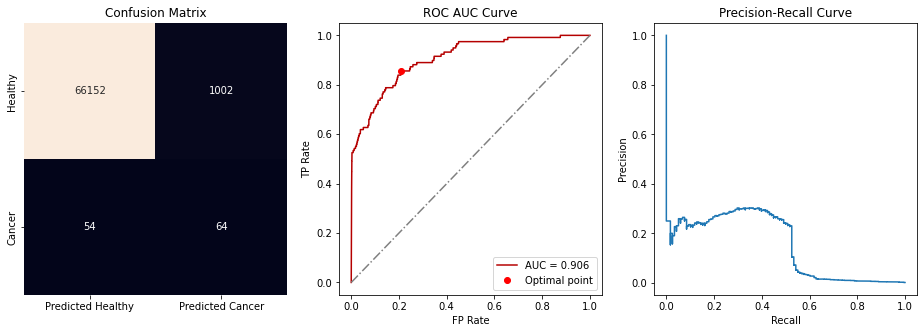

Threshold: 0.10476013273000717
     precision    recall  f1-score  support
0.0   0.999662  0.791718   0.88362  67154.0
1.0   0.007099  0.847458   0.01408    118.0
ROC AUC score: 0.9062214954445714
Accuracy Score: 0.7918153169223451
0.10476013


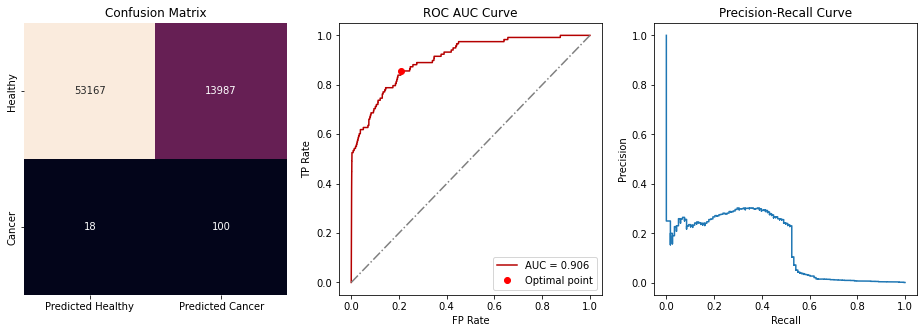

0.10476013
Filtered on: ('was_screened', [0])
     precision  recall  f1-score  support
0.0   0.000000     0.0  0.000000    167.0
1.0   0.233945     1.0  0.379182     51.0
ROC AUC score: 0.552541974873782
Accuracy Score: 0.23394495412844038
0.99230015


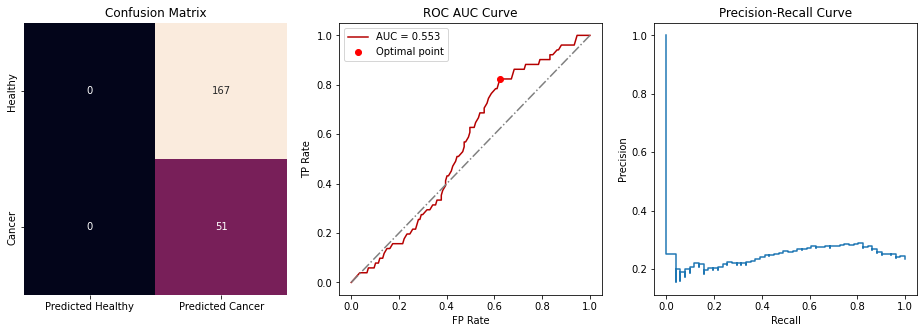

Filtered on: ('was_screened', [1])
     precision    recall  f1-score  support
0.0   0.999184  0.987535  0.993325  66987.0
1.0   0.015330  0.194030  0.028415     67.0
ROC AUC score: 0.837645040951363
Accuracy Score: 0.9867420288125988
0.10476013


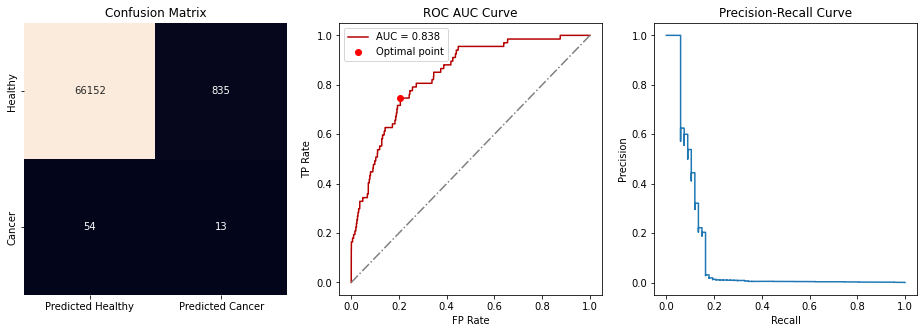

Filtered on: ('ovar_histtype', [2])
     precision    recall  f1-score  support
0.0   0.866667  0.716912  0.784708    272.0
1.0   0.300000  0.523810  0.381503     63.0
ROC AUC score: 0.6743405695611578
Accuracy Score: 0.6805970149253732
0.08119844


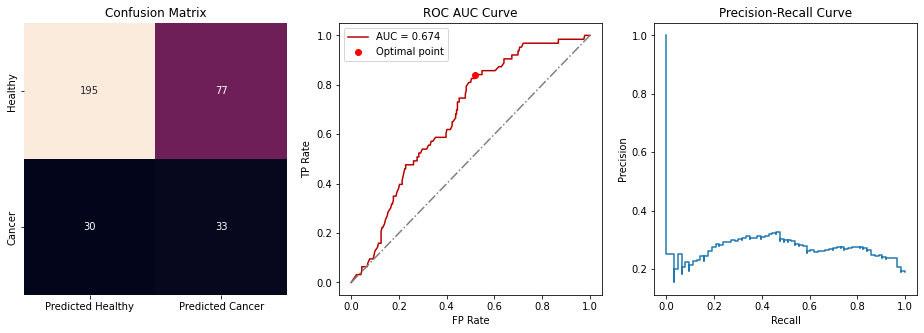

Filtered on: ('ovar_histtype', [2, 4, 6, 8, 9, 31])
     precision    recall  f1-score  support
0.0   0.871134  0.671968  0.758698    503.0
1.0   0.266667  0.545455  0.358209    110.0
ROC AUC score: 0.675456352792337
Accuracy Score: 0.6492659053833605
0.10476013


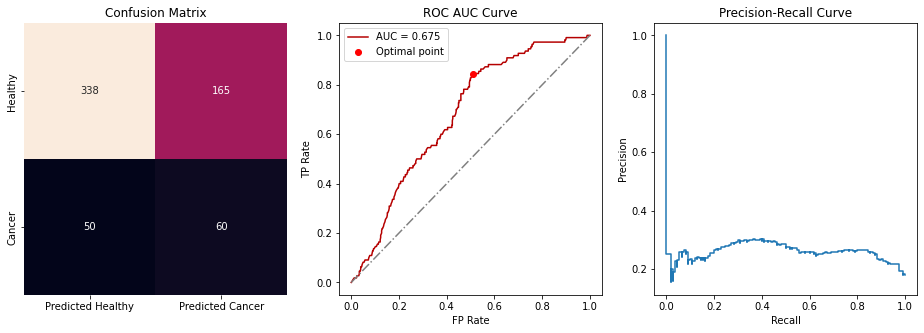

In [14]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
years = [1]
drop_n_features = 1
cv=False
for year in years:
    label = f'cancer_in_next_{year}_years' # 'cancer_in_next_10_years', 'ovar_cancer'
    df_top_feature_importances, df_feature_importance_tree, X_test_mismatch = run_classifiers(classifiers, processed_data_filtered, label, strategy='mean', cv=cv, drop_n_features = drop_n_features, num_folds=5, plot_tree=False, differentiate_confusion_matrix_over=differentiate_confusion_matrix_over)


In [15]:
len(X_test_mismatch)

54

In [16]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.14151879]
print_df(false_negatives)

+-------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+--------+---------+----------+----------+--------------+--------------+--------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+------

In [17]:
len(false_negatives)

25

In [18]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+--------+---------+----------+----------+--------------+--------------+--------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+----------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+---

In [19]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+----------+----------+------------+------------+-----------------+-----------+------------+-------------+-----------+-----------+----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+---------------+--------------+---------+-------------+-------------+-----------+-----------+-----------+-----------+----------+----------+--------------+--------------+------------+--------------------------+-------------------------------+-------------------------------+------------+
|        |   bmi_20 |   bmi_50 |   bmi_curr |   brothers |   ca125ii_level |   fchilda |   height_f |   lantero_p |   llong_p |   ltran_p |   lvol_p |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   ovcyst_volr |   ph_any_dhq |   prega |   rantero_p |   rantero_q |   rlong_p |   rlong_q |   rtran_p |   rtran_q |   rvol_p |   rvol_q |   weight20_f |   weight50_f |   weight_f |   cancer_in_next

In [21]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+-------+-----------+-----------+----------+----------+------------+------------+----------+-----------------+------------+-----------------+----------+------------+-------------+-----------+----------+-----------+------------+-------------+---------+-----------+-----------+-----------+----------+-----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+--------------+-----------+---------+---------+-------------+-----------+-----------+----------+------------+---------+-----------+--------------+---------------+--------------+--------------+------------+------------+
|        |   age |   bcontra |   bcontrt |   bmi_20 |   bmi_50 |   bmi_curc |   bmi_curr |   bq_age |   breast_fh_age |   brothers |   ca125ii_level |   center |   cig_stop |   cig_years |   cigpd_f |   educat |   fmenstr |   height_f |   lantero_p |   livec |   llong_p |   lmenstr |   ltran_p |   lvol_p |   occupat |   ovary_diam |   ovary_diaml |   ov